In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/deforestation_detection/amazon-satellite-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: train-jpg/train-jpg/train_55.jpg  
  inflating: train-jpg/train-jpg/train_550.jpg  
  inflating: train-jpg/train-jpg/train_5500.jpg  
  inflating: train-jpg/train-jpg/train_5501.jpg  
  inflating: train-jpg/train-jpg/train_5502.jpg  
  inflating: train-jpg/train-jpg/train_5503.jpg  
  inflating: train-jpg/train-jpg/train_5504.jpg  
  inflating: train-jpg/train-jpg/train_5505.jpg  
  inflating: train-jpg/train-jpg/train_5506.jpg  
  inflating: train-jpg/train-jpg/train_5507.jpg  
  inflating: train-jpg/train-jpg/train_5508.jpg  
  inflating: train-jpg/train-jpg/train_5509.jpg  
  inflating: train-jpg/train-jpg/train_551.jpg  
  inflating: train-jpg/train-jpg/train_5510.jpg  
  inflating: train-jpg/train-jpg/train_5511.jpg  
  inflating: train-jpg/train-jpg/train_5512.jpg  
  inflating: train-jpg/train-jpg/train_5513.jpg  
  inflating: train-jpg/train-jpg/train_5514.jpg  
  inflating: train-jpg/train-jpg/train_5515.jpg  
  i

In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Metric, Precision, Recall
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Load labels
labels_df = pd.read_csv('/content/train_v2.csv/train_v2.csv')

94765736/94765736 [==============================] - 0s 0us/step


In [6]:
# Create binary labels for 'habitation' and 'slash_burn'
labels_df['deforestation'] = labels_df['tags'].apply(lambda x: 1 if 'habitation' in x else 0)
labels_df['pollution'] = labels_df['tags'].apply(lambda x: 1 if 'slash_burn' in x else 0)

In [7]:
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

In [8]:
train_df['image_name'] = train_df['image_name'].apply(lambda x: f"{x}.jpg")
val_df['image_name'] = val_df['image_name'].apply(lambda x: f"{x}.jpg")

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_dataset_generator(df, data_dir, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        df, directory=data_dir, x_col='image_name', y_col=['deforestation', 'pollution'],
        target_size=target_size, batch_size=batch_size, class_mode='raw')
    return generator

data_dir = '/content/train-jpg/train-jpg'

train_generator = create_dataset_generator(train_df, data_dir)
val_generator = create_dataset_generator(val_df, data_dir)

Found 32383 validated image filenames.
Found 8096 validated image filenames.


In [10]:
from tensorflow.keras.layers import Dropout


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
for layer in base_model.layers:
    layer.trainable = False


# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
1012/1012 [==============================] - 153s 140ms/step - loss: 0.1715 - auc: 0.7596 - val_loss: 0.1591 - val_auc: 0.8801
Epoch 2/10
1012/1012 [==============================] - 139s 138ms/step - loss: 0.1588 - auc: 0.8072 - val_loss: 0.1541 - val_auc: 0.8799
Epoch 3/10
1012/1012 [==============================] - 139s 137ms/step - loss: 0.1541 - auc: 0.8252 - val_loss: 0.1541 - val_auc: 0.8845
Epoch 4/10
1012/1012 [==============================] - 139s 137ms/step - loss: 0.1523 - auc: 0.8328 - val_loss: 0.1487 - val_auc: 0.8866
Epoch 5/10
1012/1012 [==============================] - 144s 142ms/step - loss: 0.1508 - auc: 0.8378 - val_loss: 0.1545 - val_auc: 0.8808
Epoch 6/10
1012/1012 [==============================] - 139s 137ms/step - loss: 0.1482 - auc: 0.8478 - val_loss: 0.1768 - val_auc: 0.8718
Epoch 7/10
1012/1012 [==============================] - 139s 137ms/step - loss: 0.1462 - auc: 0.8554 - val_loss: 0.1435 - val_auc: 0.8837
Epoch 8/10
1012/1012 [============

In [15]:
from tensorflow.keras.preprocessing import image

def predict_deforestation_pollution(model, img_path, img_size=(224, 224)):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Make a prediction using model
    preds = model.predict(x)

    return preds

1/1 [==============================] - 2s 2s/step


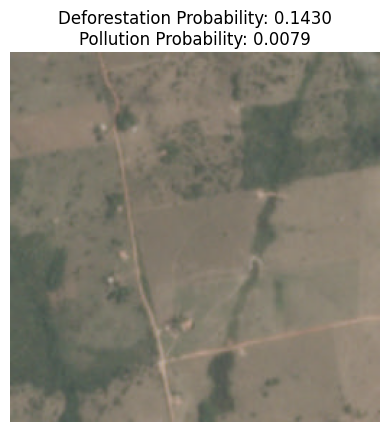

1/1 [==============================] - 0s 23ms/step


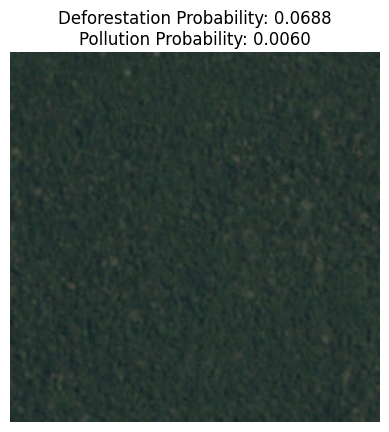

1/1 [==============================] - 0s 23ms/step


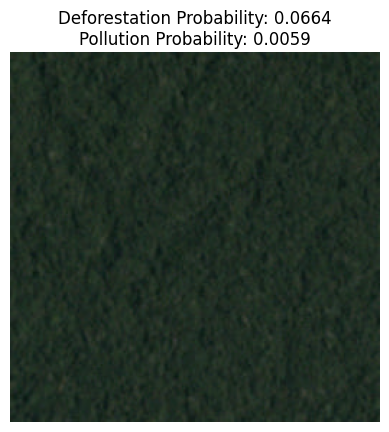

1/1 [==============================] - 0s 22ms/step


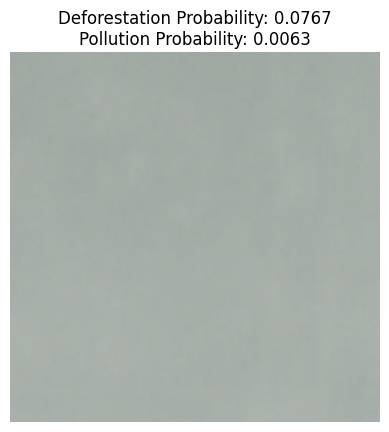

1/1 [==============================] - 0s 22ms/step


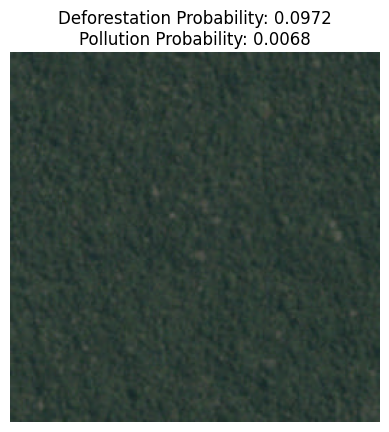

In [16]:
import os
import random
import matplotlib.pyplot as plt

def display_image_with_predictions(img_path, deforestation_prob, pollution_prob):
    img = image.load_img(img_path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Deforestation Probability: {deforestation_prob:.4f}\nPollution Probability: {pollution_prob:.4f}")
    plt.axis("off")
    plt.show()

# Set path to the test dataset directory
test_data_dir = '/content/test-jpg/test-jpg'

# Choose a few random images from test dataset
test_images = random.sample(os.listdir(test_data_dir), 5)

# Evaluate model's performance on selected test images
for img_name in test_images:
    img_path = os.path.join(test_data_dir, img_name)
    preds = predict_deforestation_pollution(model, img_path)

    deforestation_prob = preds[0][0]
    pollution_prob = preds[0][1]

    display_image_with_predictions(img_path, deforestation_prob, pollution_prob)

In [17]:
model.save('deforestation_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from tensorflow.keras.models import load_model
import cv2
# Load the entire model
loaded_model = load_model('deforestation_model.h5')

1/1 [==============================] - 0s 81ms/step
[[0.11211105 0.0071946 ]]


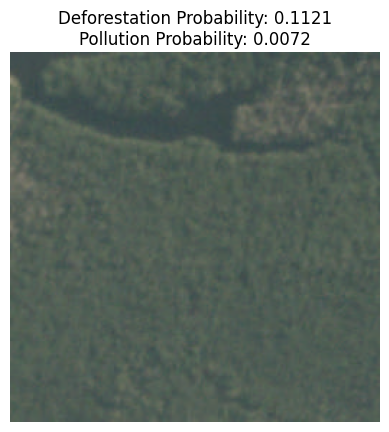

In [19]:
img_path = "/content/test-jpg-additional/test-jpg-additional/file_100.jpg"
img_size=(224, 224)
img = image.load_img(img_path, target_size=img_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
preds = model.predict(x)
print(preds)
deforestation_prob = preds[0][0]
pollution_prob = preds[0][1]
img = image.load_img(img_path)

plt.figure()
plt.imshow(img)
plt.title(f"Deforestation Probability: {deforestation_prob:.4f}\nPollution Probability: {pollution_prob:.4f}")
plt.axis("off")
plt.show()